## Environment preparation :

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

TensorFlow 1.x selected.
1.15.2


True

In [ ]:
from google.colab import drive
drive.mount("/content/drive/", errors='replace')

## Data Preparation for the first training:

Here we focus on the topview angle which is needed for an interctive projection solution

In [ ]:
import os
import shutil
shutil.rmtree('/content/dataset', ignore_errors=True)
!unzip -qq '/content/drive/My Drive/NYU.zip' -d /content/

In [ ]:
### Creating train1 and test folders:
import os
import shutil


os.mkdir("/content/dataset/train1")

lista = sum([[i*300 for i in range(40)],[i*300+30000 for i in range(40)],[i*300+45000 for i in range(60)]],[])
list_topview = [300,600,1800,2400,2700,3300,3900,6900,7200,8400,9900,10200,11100,16200,16500,18000,19200,19500,19800,20700,21600,22800,24300,26400,27600,27900,29700,31800,37200,37500,37800,38100,38400,42000,42300,42900,43200,45900,46200,49800,50100,50400,50700,51000,51300,51600,51900,52200,52500,53700,54000,54300,55500,56700,57000,57300,58500,59400,59700,60000,60300,60600,60900,61200,61500,62100,63300,63600,63900,68100,68400,68700,69000,69600]
list_all=list(set(sum([lista,list_topview],[])))
for r in list_all:
  for id in range(r,r+300):
    try :
      id = str(id)
      l = len(id)
      while l<7:
        id = '0'+id
        l+=1
      shutil.move(os.path.join("/content/dataset/train",'depth_1_'+id+'.png'), os.path.join("/content/dataset/train1",'depth_1_'+id+'.png')) 
    except :
      continue


In [ ]:
shutil.rmtree('/content/dataset/train', ignore_errors=True)

os.rename('/content/dataset/test','/content/dataset/train')
os.mkdir('/content/dataset/test')
import random

list = random.sample(os.listdir("/content/dataset/train1"), 5000)
for f in list:
    try :
      shutil.move(os.path.join("/content/dataset/train1",f), os.path.join("/content/dataset/test",f)) 
    except :
      continue

In [ ]:
len(os.listdir("/content/dataset/train1"))

44799

In [ ]:
!unzip -j '/content/drive/My Drive/NYU.zip' 'dataset/train/joint_data.mat' -d'/content/dataset/train1/'
!unzip -j '/content/drive/My Drive/NYU.zip' 'dataset/train/joint_data.mat' -d '/content/dataset/test/'

Archive:  /content/drive/My Drive/NYU.zip
  inflating: /content/dataset/train1/joint_data.mat  
Archive:  /content/drive/My Drive/NYU.zip
  inflating: /content/dataset/test/joint_data.mat  


## First Training (All views)  

In [ ]:
import shutil
import os
shutil.rmtree('/content/dataset/train', ignore_errors=True)

os.rename('/content/dataset/train1','/content/dataset/train')

In [ ]:
os.chdir('/')
%cd '/content/drive/My Drive/CrossinfoNet'
#####

### Please download crossinfonet folder from the github repo 

###

/content/drive/My Drive/CrossinfoNet


In [ ]:
import sys
#sys.path.append('../../')#add root directory
from data.importers import NYUImporter
from util.handdetector import HandDetector
from data.transformations import transformPoints2D

import numpy as np
from util.preprocess import augmentCrop,norm_dm,joints_heatmap_gen
import tensorflow as tf
rng=np.random.RandomState(23455)

from netlib.basemodel import basenet2


In [ ]:
train_root='/content/dataset'
di_train = NYUImporter(train_root, useCache=False, cacheDir='/content/handpose/cache/NYU/',refineNet=None,allJoints=False)

Seq_train = di_train.loadSequence('train', rng=rng, shuffle=True, docom=False,cube=None)
train_num=len(Seq_train.data)
cubes_train = np.asarray([d.cube for d in Seq_train.data], 'float32')
coms_train = np.asarray([d.com for d in Seq_train.data], 'float32')
Ms_train = np.asarray([d.T for d in Seq_train.data], dtype='float32')
gt3Dcrops_train = np.asarray([d.gt3Dcrop for d in Seq_train.data], dtype='float32')
imgs_train = np.asarray([d.dpt.copy() for d in Seq_train.data], 'float32')


di_test = NYUImporter(train_root,  useCache=False, cacheDir='/content/handpose/cache/NYU/',refineNet=None,allJoints=False)
Seq_test = di_test.loadSequence('test', rng=rng, shuffle=True, docom=False,cube=(250,250,250))
test_num=len(Seq_test.data)
cubes_test = np.asarray([d.cube for d in Seq_test.data], 'float32')
coms_test = np.asarray([d.com for d in Seq_test.data], 'float32')
gt3Dcrops_test = np.asarray([d.gt3Dcrop for d in Seq_test.data], dtype='float32')
imgs_test = np.asarray([d.dpt.copy() for d in Seq_test.data], 'float32')
test_data=np.ones_like(imgs_test)
test_label=np.ones_like(gt3Dcrops_test)
for it in range(test_num):
    test_data[it]=norm_dm(imgs_test[it],coms_test[it],cubes_test[it])
    test_label[it]=gt3Dcrops_test[it]/(cubes_test[it][0]/2.)
test_data=np.expand_dims(test_data,3)
test_label=np.reshape(test_label,(-1,42))

print "training data {}".format(imgs_train.shape[0])
print "testing data {}".format(imgs_test.shape[0])
print "done"



/content/dataset/train/joint_data.mat


Loading trainN/A%|                                                            |

******
Loading train


Loading train100%|############################################################|


Loaded 44799 samples.
Shuffling
/content/dataset/test/joint_data.mat


Loading testN/A%|                                                             |

******
Loading test


Loading test100%|#############################################################|


Loaded 5000 samples.
Shuffling
training data 44799
testing data 5000
done


Exemple of training data:

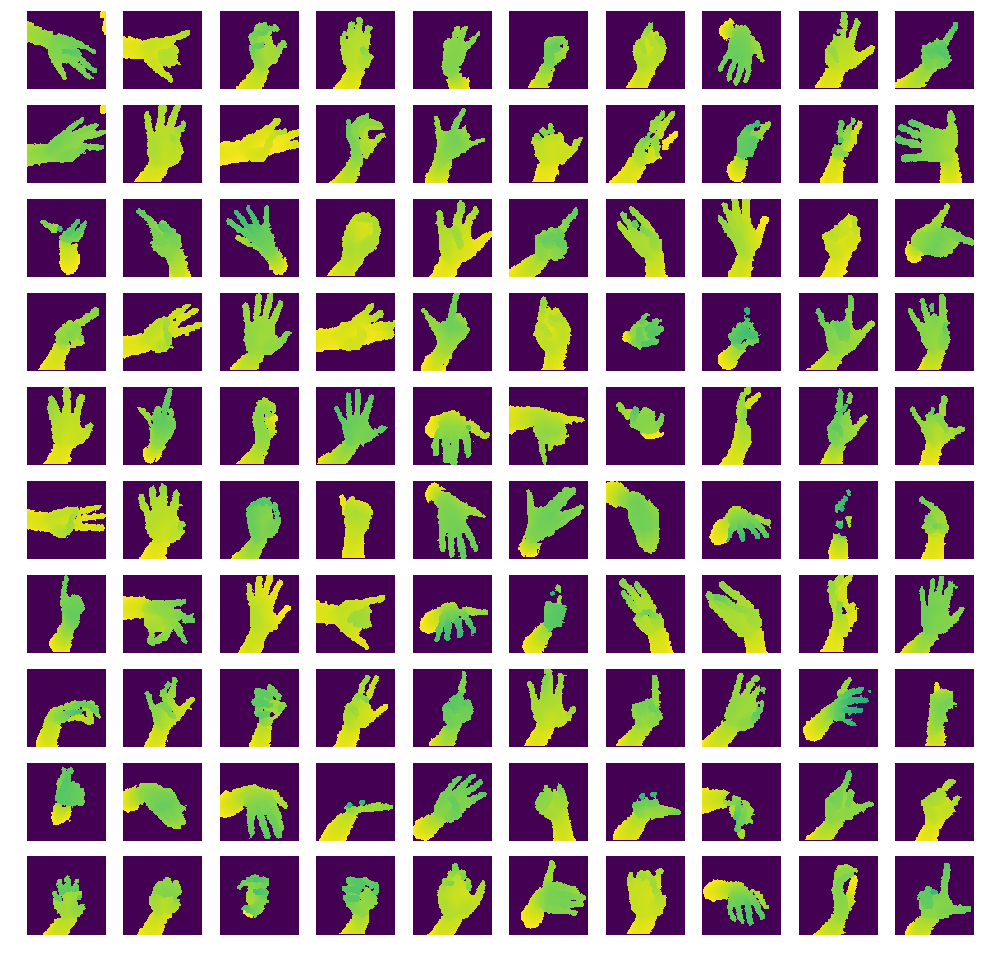

In [ ]:
import matplotlib.pyplot as plt
import random
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() 
n_training = len(imgs_train) 
for i in range(L_grid*W_grid):
  index = random.randint(0,n_training) 
  axes[i].imshow(imgs_train[index])
  axes[i].axis('off')



In [ ]:
visual_aug=True

hand_edges=[[0,1],[2,3],[4,5],[6,7],[8,9],[9,10],[13,10],[13,1],[13,3],[13,5],[13,7],[13,11],[13,12]]


hd=HandDetector(imgs_train[0].copy(),abs(588.03),abs(587.07),di_train,refineNet=None)

inputs=tf.placeholder(dtype=tf.float32,shape=(None,96,96,1))
label=tf.placeholder(dtype=tf.float32,shape=(None,42))
gt_ht=tf.placeholder(dtype=tf.float32,shape=(None,24,24,14))
is_train=tf.placeholder(dtype=tf.bool,shape=None)

kp=tf.placeholder(dtype=tf.float32,shape=None)

batch_size=196
last_e=100
outdims=(14,9,5)
#################################################################
import tensorflow.contrib.slim as slim
import tensorflow.contrib.layers as layers

fn=layers.l2_regularizer(1e-5)
fn0=tf.no_regularizer

with slim.arg_scope([slim.conv2d, slim.fully_connected],
                    weights_regularizer=fn,
                    biases_regularizer=fn0,
                    normalizer_fn=slim.batch_norm):
    with slim.arg_scope([slim.batch_norm],
                        is_training=is_train,
                        updates_collections=None,
                        decay=0.9,
                        center=True,
                        scale=True,
                        epsilon=1e-5):
        pred_comb_ht, pred_comb_hand, pred_hand, pred_ht=basenet2(inputs,kp=kp,is_training=is_train,outdims=outdims)


gt_fing_ht=gt_ht[:,:,:,0:10][:,:,:,0::2]
gt_palm_ht = tf.concat((gt_ht[:,:,:,0:10][:, :,:,1::2], gt_ht[:,:,:, 10:]), 3)

label1=tf.reshape(label,(-1,14,3))
gt_fing = tf.reshape(label1[:, 0:10, :][:, 0::2, :], (-1, 5 * 3))
gt_palm = tf.reshape(tf.concat((label1[:, 0:10, :][:, 1::2, :], label1[:, 10:, :]), 1),(-1,9*3))


loss_ht=tf.nn.l2_loss((pred_ht-gt_ht))/batch_size
loss_hand=tf.nn.l2_loss((pred_hand-label))/batch_size

loss_palm_ht=tf.nn.l2_loss((pred_comb_ht[0]-gt_palm_ht))/batch_size
loss_fing_ht=tf.nn.l2_loss((pred_comb_ht[1]-gt_fing_ht))/batch_size

loss_palm=tf.nn.l2_loss((pred_comb_hand[0]-gt_palm))/batch_size
loss_fing=tf.nn.l2_loss((pred_comb_hand[1]-gt_fing))/batch_size

weight_decay = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
weight_decay = tf.add_n(weight_decay)


loss=0.5*(0.01*(loss_ht+loss_palm_ht+loss_fing_ht)+loss_hand+loss_palm+loss_fing)+weight_decay

#################################################################
def getMeanError(gt, joints):
    return np.nanmean(np.nanmean(np.sqrt(np.square(gt - joints).sum(axis=2)), axis=1))
#################################################################


lr = tf.Variable((1e-3), dtype=tf.float32, trainable=False)
global_step = tf.Variable(0, trainable=False)


optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss, global_step)

tf.summary.scalar("loss",loss)
tf.summary.scalar('lr',lr)

summ=tf.summary.merge_all()
saver=tf.train.Saver(max_to_keep=15)


In [ ]:
del list
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    writer = tf.summary.FileWriter('/tensorboard.events9/', sess.graph)
    losses_iter = []

    training_batch = (zip(range(0, train_num, batch_size),
                          range(batch_size, train_num + 1, batch_size)))
    for itrain in range(30):
        kpv = 0.6
        c = list(zip(cubes_train, coms_train, Ms_train, gt3Dcrops_train, imgs_train))
        rng.shuffle(c)
        cubes_train, coms_train, Ms_train, gt3Dcrops_train, imgs_train = zip(*c)
        cubes_train = np.asarray(cubes_train)
        coms_train = np.asarray(coms_train)
        Ms_train = np.asarray(Ms_train)
        gt3Dcrops_train = np.asarray(gt3Dcrops_train)
        imgs_train = np.asarray(imgs_train)

        lr_update = tf.assign(lr, (1e-3) * 0.96 ** itrain)
        sess.run(lr_update)

        for start, end in training_batch:
          try:
            subdata = imgs_train[start:end].copy()
            subcom = coms_train[start:end].copy()
            subcube = cubes_train[start:end].copy()
            subM = Ms_train[start:end].copy()
            subgt3Dcrop = gt3Dcrops_train[start:end].copy()
            resdata=np.ones_like(subdata)
            resgt3D=np.ones_like(subgt3Dcrop)
            hts=np.zeros(shape=(batch_size,24,24,14))
            jtIs=np.zeros(shape=(batch_size,42))

            for idx in range(batch_size):
                dm = norm_dm(subdata[idx], subcom[idx], subcube[idx])
                s = augmentCrop(dm, subgt3Dcrop[idx], di_train.joint3DToImg(subcom[idx]),
                                subcube[idx], subM[idx],['com', 'rot', 'none','sc'], hd, False, rng=rng)
                resdata[idx] = s[0]
                resgt3D[idx] = s[2]
                mode=s[7]
                gt3D_ = resgt3D[idx] * subcube[idx][0] / 2. + subcom[idx]
                jtI_ = transformPoints2D(di_train.joints3DToImg(gt3D_), subM[idx])
                jtI_=np.reshape(jtI_,(1,42))
                ht_=joints_heatmap_gen([1],jtI_,(24,24),points=14)
                hts[idx]=np.transpose(ht_,(0,2,3,1))/255.


            feed_dict = {inputs: resdata.reshape(-1, 96, 96, 1),
                         label: resgt3D.reshape(-1, 42),
                         gt_ht:hts,
                         is_train:True,
                         kp:kpv
                         }
            _, losses,summs,steps = sess.run([optimizer, loss,summ,global_step], feed_dict=feed_dict)
            if (start/batch_size)%2 ==0:
            writer.add_summary(summs,steps)
              print itrain,start/batch_size,losses,mode

          except :
            continue       
        pred_norm=[]
        loopv = test_num // batch_size
        other = test_data[loopv * batch_size:]
        k=0
        for itest in xrange(loopv + 1):
            if itest < loopv:
                start = itest * batch_size
                end = (itest + 1) * batch_size
                feed_dict = {inputs: test_data[start:end],is_train:False,kp:kpv}
            else:
                feed_dict = {inputs: other,is_train:False,kp:kpv}
            try :
    
              [pred_] = sess.run([pred_hand], feed_dict=feed_dict)
              pred_norm.append(pred_)
            except:
              pred_norm.append(pred_norm[-1])
              k=1
              continue
        if k ==1:
          pred_norm = pred_norm[:-1]
        norm_hands = np.concatenate(pred_norm, 0).reshape(-1, 14, 3)
        pred_hands = norm_hands * np.tile(np.expand_dims(cubes_test / 2., 1), (1, 14, 1)) + \
                     np.tile(np.expand_dims(coms_test, 1),(1, 14, 1))
        gt_hands = test_label.reshape(-1, 14, 3) * np.tile(np.expand_dims(cubes_test / 2., 1), (1, 14, 1)) + \
                     np.tile(np.expand_dims(coms_test, 1), (1, 14, 1))
        meane = getMeanError(gt_hands, pred_hands)
        print "mean error : ",meane
        logt = open('logs/log_NYU_first_training_final', 'a+')
        logt.write('epoch {}, mean error {}'.format(itrain,meane))
        logt.write('\n')
        logt.close()
        losses_iter.append(meane)

        if last_e>=meane:
            last_e=meane
            saver.save(sess,'model/crossInfoNet_NYU_first_training_final.ckpt')
            logt = open('logs/log_NYU_first_training_final.txt', 'a+')
            logt.write("*********************")
            logt.write('\n')
            logt.write('current best epoch is {}, mean error is {}'.format(itrain,last_e))
            logt.write('\n')
            logt.write("*********************")
            logt.write('\n')
            logt.close()


0 0 60.878056 sc
0 2 52.536446 sc
0 4 49.84657 none
0 6 47.17412 com
0 8 45.66783 rot
0 10 45.11728 com
0 12 44.39432 sc
0 14 43.90498 sc
0 16 42.982113 sc
0 18 42.59495 none
0 20 42.935402 rot
0 22 41.982468 none
0 24 41.455044 sc
0 26 41.006317 com
0 28 40.16643 sc
0 30 39.636787 rot
0 32 38.773304 rot
0 34 37.91961 sc
0 36 37.04965 none
0 38 36.111496 none
0 40 36.187897 com
0 42 35.23534 com
0 44 35.1804 sc
0 46 34.998737 com
0 48 34.612434 none
0 50 33.996918 none
0 52 34.12294 none
0 54 33.94789 none
0 56 33.600216 none
0 58 33.433086 sc
0 60 33.722195 sc
0 62 33.248356 rot
0 64 33.0742 com
0 66 32.839638 none
0 68 32.39794 rot
0 70 32.229282 sc
0 72 32.09572 rot
0 74 32.16399 com
0 76 31.966583 com
0 78 31.519672 com
0 80 31.32821 com
0 82 31.408512 rot
0 84 31.029913 sc
0 86 30.756023 rot
0 88 30.49305 sc
0 90 30.693888 none
0 92 30.326109 none
0 94 30.21769 rot
0 96 30.42169 none
0 98 30.08992 com
0 100 29.704975 sc
0 102 29.720726 none
0 104 29.425114 sc
0 106 29.147514 com
0

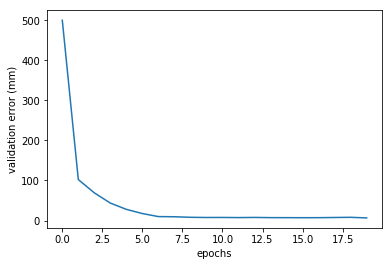

In [ ]:
## plot the error's variation
import matplotlib.pyplot as plt

iters = np.arange(len(losses_iter))

fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('epochs')
ax.set_ylabel('validation error (mm)')

ax.plot(iters, losses_iter)

## Data Preparation for the second training:

In [ ]:
import os
import shutil
shutil.rmtree('/content/dataset', ignore_errors=True)
!unzip -qq '/content/drive/My Drive/NYU.zip' -d /content/

In [ ]:
### Creating train1 and test folders:
import os
import shutil

os.mkdir("/content/dataset/train1")

list_topview = [300,600,1800,2400,2700,3300,3900,6900,7200,8400,9900,10200,11100,16200,16500,18000,19200,19500,19800,20700,21600,22800,24300,26400,27600,27900,29700,31800,37200,37500,37800,38100,38400,42000,42300,42900,43200,45900,46200,49800,50100,50400,50700,51000,51300,51600,51900,52200,52500,53700,54000,54300,55500,56700,57000,57300,58500,59400,59700,60000,60300,60600,60900,61200,61500,62100,63300,63600,63900,68100,68400,68700,69000,69600]
for r in list_topview:
  for id in range(r,r+300):
    try :
      id = str(id)
      l = len(id)
      while l<7:
        id = '0'+id
        l+=1
      shutil.move(os.path.join("/content/dataset/train",'depth_1_'+id+'.png'), os.path.join("/content/dataset/train1",'depth_1_'+id+'.png')) 
    except :
      continue


In [ ]:
shutil.rmtree('/content/dataset/train', ignore_errors=True)

os.rename('/content/dataset/test','/content/dataset/train')
os.mkdir('/content/dataset/test')
import random

list = random.sample(os.listdir("/content/dataset/train1"), 3000)
for f in list:
    try :
      shutil.move(os.path.join("/content/dataset/train1",f), os.path.join("/content/dataset/test",f)) 
    except :
      continue

In [ ]:
len(os.listdir("/content/dataset/train1"))

19200

In [ ]:
!unzip -j '/content/drive/My Drive/NYU.zip' 'dataset/train/joint_data.mat' -d'/content/dataset/train1/'
!unzip -j '/content/drive/My Drive/NYU.zip' 'dataset/train/joint_data.mat' -d '/content/dataset/test/'

Archive:  /content/drive/My Drive/NYU.zip
  inflating: /content/dataset/train1/joint_data.mat  
Archive:  /content/drive/My Drive/NYU.zip
  inflating: /content/dataset/test/joint_data.mat  


## Second Training (top view mainly)  

In [ ]:
import shutil
import os
shutil.rmtree('/content/dataset/train', ignore_errors=True)

os.rename('/content/dataset/train1','/content/dataset/train')

In [ ]:
os.chdir('/')
%cd '/content/drive/My Drive/CrossinfoNet'

/content/drive/My Drive/CrossinfoNet


In [ ]:
import sys
#sys.path.append('../../')#add root directory
from data.importers import NYUImporter
from util.handdetector import HandDetector
from data.transformations import transformPoints2D

import numpy as np
from util.preprocess import augmentCrop,norm_dm,joints_heatmap_gen
import tensorflow as tf
rng=np.random.RandomState(23455)

from netlib.basemodel import basenet2


In [ ]:
train_root='/content/dataset'
di_train = NYUImporter(train_root, useCache=False, cacheDir='/content/handpose/cache/NYU/',refineNet=None,allJoints=False)

Seq_train = di_train.loadSequence('train', rng=rng, shuffle=True, docom=False,cube=None)
train_num=len(Seq_train.data)
cubes_train = np.asarray([d.cube for d in Seq_train.data], 'float32')
coms_train = np.asarray([d.com for d in Seq_train.data], 'float32')
Ms_train = np.asarray([d.T for d in Seq_train.data], dtype='float32')
gt3Dcrops_train = np.asarray([d.gt3Dcrop for d in Seq_train.data], dtype='float32')
imgs_train = np.asarray([d.dpt.copy() for d in Seq_train.data], 'float32')


di_test = NYUImporter(train_root,  useCache=False, cacheDir='/content/handpose/cache/NYU/',refineNet=None,allJoints=False)
Seq_test = di_test.loadSequence('test', rng=rng, shuffle=True, docom=False,cube=(250,250,250))
test_num=len(Seq_test.data)
cubes_test = np.asarray([d.cube for d in Seq_test.data], 'float32')
coms_test = np.asarray([d.com for d in Seq_test.data], 'float32')
gt3Dcrops_test = np.asarray([d.gt3Dcrop for d in Seq_test.data], dtype='float32')
imgs_test = np.asarray([d.dpt.copy() for d in Seq_test.data], 'float32')
test_data=np.ones_like(imgs_test)
test_label=np.ones_like(gt3Dcrops_test)
for it in range(test_num):
    test_data[it]=norm_dm(imgs_test[it],coms_test[it],cubes_test[it])
    test_label[it]=gt3Dcrops_test[it]/(cubes_test[it][0]/2.)
test_data=np.expand_dims(test_data,3)
test_label=np.reshape(test_label,(-1,42))

print "training data {}".format(imgs_train.shape[0])
print "testing data {}".format(imgs_test.shape[0])
print "done"



/content/dataset/train/joint_data.mat


Loading trainN/A%|                                                            |

******
Loading train


Loading train100%|############################################################|


Loaded 19200 samples.
Shuffling
/content/dataset/test/joint_data.mat


Loading testN/A%|                                                             |

******
Loading test


Loading test100%|#############################################################|


Loaded 3000 samples.
Shuffling
training data 19200
testing data 3000
done


In [ ]:
visual_aug=True

hand_edges=[[0,1],[2,3],[4,5],[6,7],[8,9],[9,10],[13,10],[13,1],[13,3],[13,5],[13,7],[13,11],[13,12]]


hd=HandDetector(imgs_train[0].copy(),abs(588.03),abs(587.07),di_train,refineNet=None)

inputs=tf.placeholder(dtype=tf.float32,shape=(None,96,96,1))
label=tf.placeholder(dtype=tf.float32,shape=(None,42))
gt_ht=tf.placeholder(dtype=tf.float32,shape=(None,24,24,14))
is_train=tf.placeholder(dtype=tf.bool,shape=None)

kp=tf.placeholder(dtype=tf.float32,shape=None)

batch_size=128
last_e=100
outdims=(14,9,5)
#################################################################
import tensorflow.contrib.slim as slim
import tensorflow.contrib.layers as layers

fn=layers.l2_regularizer(1e-5)
fn0=tf.no_regularizer

with slim.arg_scope([slim.conv2d, slim.fully_connected],
                    weights_regularizer=fn,
                    biases_regularizer=fn0,
                    normalizer_fn=slim.batch_norm):
    with slim.arg_scope([slim.batch_norm],
                        is_training=is_train,
                        updates_collections=None,
                        decay=0.9,
                        center=True,
                        scale=True,
                        epsilon=1e-5):
        pred_comb_ht, pred_comb_hand, pred_hand, pred_ht=basenet2(inputs,kp=kp,is_training=is_train,outdims=outdims)


gt_fing_ht=gt_ht[:,:,:,0:10][:,:,:,0::2]
gt_palm_ht = tf.concat((gt_ht[:,:,:,0:10][:, :,:,1::2], gt_ht[:,:,:, 10:]), 3)

label1=tf.reshape(label,(-1,14,3))
gt_fing = tf.reshape(label1[:, 0:10, :][:, 0::2, :], (-1, 5 * 3))
gt_palm = tf.reshape(tf.concat((label1[:, 0:10, :][:, 1::2, :], label1[:, 10:, :]), 1),(-1,9*3))


loss_ht=tf.nn.l2_loss((pred_ht-gt_ht))/batch_size
loss_hand=tf.nn.l2_loss((pred_hand-label))/batch_size

loss_palm_ht=tf.nn.l2_loss((pred_comb_ht[0]-gt_palm_ht))/batch_size
loss_fing_ht=tf.nn.l2_loss((pred_comb_ht[1]-gt_fing_ht))/batch_size

loss_palm=tf.nn.l2_loss((pred_comb_hand[0]-gt_palm))/batch_size
loss_fing=tf.nn.l2_loss((pred_comb_hand[1]-gt_fing))/batch_size

weight_decay = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
weight_decay = tf.add_n(weight_decay)


loss=0.5*(0.01*(loss_ht+loss_palm_ht+loss_fing_ht)+loss_hand+loss_palm+loss_fing)+weight_decay

#################################################################
def getMeanError(gt, joints):
    return np.nanmean(np.nanmean(np.sqrt(np.square(gt - joints).sum(axis=2)), axis=1))
#################################################################


lr = tf.Variable((1e-3), dtype=tf.float32, trainable=False)
global_step = tf.Variable(0, trainable=False)


optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss, global_step)

tf.summary.scalar("loss",loss)
tf.summary.scalar('lr',lr)

summ=tf.summary.merge_all()
saver=tf.train.Saver(max_to_keep=15)


In [ ]:
del list
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    #writer = tf.summary.FileWriter('/tensorboard.events9/', sess.graph)
    losses_iter = []
    saver.restore(sess,'/content/drive/My Drive/CrossinfoNet/model/crossInfoNet_NYU_first_training_final.ckpt')

    training_batch = (zip(range(0, train_num, batch_size),
                          range(batch_size, train_num + 1, batch_size)))
    for itrain in range(20):
        kpv = 0.6
        c = list(zip(cubes_train, coms_train, Ms_train, gt3Dcrops_train, imgs_train))
        rng.shuffle(c)
        cubes_train, coms_train, Ms_train, gt3Dcrops_train, imgs_train = zip(*c)
        cubes_train = np.asarray(cubes_train)
        coms_train = np.asarray(coms_train)
        Ms_train = np.asarray(Ms_train)
        gt3Dcrops_train = np.asarray(gt3Dcrops_train)
        imgs_train = np.asarray(imgs_train)

        lr_update = tf.assign(lr, (1e-3) * 0.96 ** itrain)
        sess.run(lr_update)

        for start, end in training_batch:
          try:
            subdata = imgs_train[start:end].copy()
            subcom = coms_train[start:end].copy()
            subcube = cubes_train[start:end].copy()
            subM = Ms_train[start:end].copy()
            subgt3Dcrop = gt3Dcrops_train[start:end].copy()
            resdata=np.ones_like(subdata)
            resgt3D=np.ones_like(subgt3Dcrop)
            hts=np.zeros(shape=(batch_size,24,24,14))
            jtIs=np.zeros(shape=(batch_size,42))

            for idx in range(batch_size):
                dm = norm_dm(subdata[idx], subcom[idx], subcube[idx])
                s = augmentCrop(dm, subgt3Dcrop[idx], di_train.joint3DToImg(subcom[idx]),
                                subcube[idx], subM[idx],['com', 'rot', 'none','sc'], hd, False, rng=rng)
                resdata[idx] = s[0]
                resgt3D[idx] = s[2]
                mode=s[7]
                gt3D_ = resgt3D[idx] * subcube[idx][0] / 2. + subcom[idx]
                jtI_ = transformPoints2D(di_train.joints3DToImg(gt3D_), subM[idx])
                jtI_=np.reshape(jtI_,(1,42))
                ht_=joints_heatmap_gen([1],jtI_,(24,24),points=14)
                hts[idx]=np.transpose(ht_,(0,2,3,1))/255.


            feed_dict = {inputs: resdata.reshape(-1, 96, 96, 1),
                         label: resgt3D.reshape(-1, 42),
                         gt_ht:hts,
                         is_train:True,
                         kp:kpv
                         }
            _, losses,summs,steps = sess.run([optimizer, loss,summ,global_step], feed_dict=feed_dict)
            if (start/batch_size)%2 ==0:
            #writer.add_summary(summs,steps)
              print itrain,start/batch_size,losses,mode
            if (start/batch_size)%200 ==0:
              saver.save(sess,'model/crossInfoNet_NYU_second_training_final.ckpt')
          except :
            continue       
        pred_norm=[]
        loopv = test_num // batch_size
        other = test_data[loopv * batch_size:]
        k=0
        for itest in xrange(loopv + 1):
            if itest < loopv:
                start = itest * batch_size
                end = (itest + 1) * batch_size
                feed_dict = {inputs: test_data[start:end],is_train:False,kp:kpv}
            else:
                feed_dict = {inputs: other,is_train:False,kp:kpv}
            try :
    
              [pred_] = sess.run([pred_hand], feed_dict=feed_dict)
              pred_norm.append(pred_)
            except:
              pred_norm.append(pred_norm[-1])
              k=1
              continue
        if k ==1:
          pred_norm = pred_norm[:-1]
        norm_hands = np.concatenate(pred_norm, 0).reshape(-1, 14, 3)
        pred_hands = norm_hands * np.tile(np.expand_dims(cubes_test / 2., 1), (1, 14, 1)) + \
                     np.tile(np.expand_dims(coms_test, 1),(1, 14, 1))
        gt_hands = test_label.reshape(-1, 14, 3) * np.tile(np.expand_dims(cubes_test / 2., 1), (1, 14, 1)) + \
                     np.tile(np.expand_dims(coms_test, 1), (1, 14, 1))
        meane = getMeanError(gt_hands, pred_hands)
        print "mean error : ",meane
        logt = open('logs/log_NYU_second_training_final.txt', 'a+')
        logt.write('epoch {}, mean error {}'.format(itrain,meane))
        logt.write('\n')
        logt.close()
        losses_iter.append(meane)

        if last_e>=meane:
            last_e=meane
            saver.save(sess,'model/crossInfoNet_NYU_second_training_final.ckpt')
            logt = open('logs/log_NYU_second_training_final.txt', 'a+')
            logt.write("*********************")
            logt.write('\n')
            logt.write('current best epoch is {}, mean error is {}'.format(itrain,last_e))
            logt.write('\n')
            logt.write("*********************")
            logt.write('\n')
            logt.close()


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/CrossinfoNet/model/crossInfoNet_NYU_first_training_final.ckpt
0 0 0.28199214 none
0 2 0.36117327 rot
0 4 0.33050522 none
0 6 0.39750233 com
0 8 0.31184268 sc
0 10 0.35504538 sc
0 12 0.31976765 com
0 14 0.31768736 rot
0 16 0.32412282 com
0 18 0.29314882 com
0 20 0.30353242 rot
0 22 0.29371932 sc
0 24 0.34138143 rot
0 26 0.29607898 none
0 28 0.25943384 sc
0 30 0.26555634 rot
0 32 0.28318128 rot
0 34 0.27687266 sc
0 36 0.32317138 sc
0 38 0.26305607 rot
0 40 0.29487354 none
0 42 0.29824695 none
0 44 0.27944538 rot
0 46 0.2933649 sc
0 48 0.26182288 none
0 50 0.29760587 rot
0 52 0.27085483 com
0 54 0.28025678 sc
0 56 0.33869132 sc
0 58 0.29546434 sc
0 60 0.28772402 com
0 62 0.28783357 sc
0 64 0.27858135 com
0 66 0.28763503 none
0 68 0.28163245 rot
0 70 0.28064638 none
0 72 0.27788544 none
0 74 0.2962532 none
0 76 0.31510645 none
0 78 0.27577472 com
0 80 0.33377486 rot
0 82 0.31277803 none
0 84 0.29129648 com
0 86 0.28118846 co

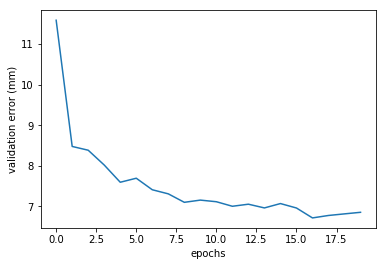

In [ ]:
## plot loss' variation
import matplotlib.pyplot as plt

iters = np.arange(len(losses_iter))

fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('epochs')
ax.set_ylabel('validation error (mm)')

ax.plot(iters, losses_iter)

## Testing : 

In [ ]:
%cd '/content/drive/My Drive/CrossinfoNet'

/content/drive/My Drive/CrossinfoNet


In [ ]:
import sys
# import matplotlib
# matplotlib.use('Agg')
from data.importers import NYUImporter
from data.transformations import transformPoints2D
from util.handdetector import HandDetector
import numpy as np
from util.preprocess import augmentCrop,norm_dm
import matplotlib.pyplot  as plt
import tensorflow as tf



rng=np.random.RandomState(23455)
from netlib.basemodel import basenet2

visual=True

train_root='/content/dataset/'
di_1 = NYUImporter(train_root, useCache=False ,cacheDir='cache/NYU/',refineNet=None,allJoints=False)
Seq_train = di_1.loadSequence('test', rng=rng, shuffle=False, docom=False,cube=(250,250,250))

test_num=len(Seq_train.data)
print test_num
cubes = np.asarray([d.cube for d in Seq_train.data], 'float32')
coms = np.asarray([d.com for d in Seq_train.data], 'float32')
Ms = np.asarray([d.T for d in Seq_train.data], dtype='float32')
gt3Dcrops = np.asarray([d.gt3Dcrop for d in Seq_train.data], dtype='float32')
imgs = np.asarray([d.dpt.copy() for d in Seq_train.data], 'float32')
test_data=np.ones_like(imgs)
test_label=np.ones_like(gt3Dcrops)


for i in range(test_num):

    test_data[i]=norm_dm(imgs[i],coms[i],cubes[i])
    test_label[i]=gt3Dcrops[i]/(cubes[i][0]/2.)
    #print cubes[i]
    # plt.imshow(test_data[i],cmap='gray')
    # print i
    # plt.pause(0.0001)
    # plt.cla()

test_data=np.expand_dims(test_data,3)
test_label=np.reshape(test_label,(-1,42))
# for i in range(test_num):
#     print cubes[i]
inputs=tf.placeholder(dtype=tf.float32,shape=(None,96,96,1))
label=tf.placeholder(dtype=tf.float32,shape=(None,42))


batch_size=128

import tensorflow.contrib.slim as slim
import tensorflow.contrib.layers as layers

fn=layers.l2_regularizer(1e-5)
fn0=tf.no_regularizer

with slim.arg_scope([slim.conv2d, slim.fully_connected],
                    weights_regularizer=fn,
                    biases_regularizer=fn0,
                    normalizer_fn=slim.batch_norm):
    with slim.arg_scope([slim.batch_norm],
                        is_training=False,
                        updates_collections=None,
                        decay=0.9,
                        center=True,
                        scale=True,
                        epsilon=1e-5):
        pred_comb_ht, pred_comb_hand, pred_hand, pred_ht=basenet2(inputs,kp=1,is_training=False)



/content/dataset//test/joint_data.mat


Loading testN/A%|                                                             |

******
Loading test


Loading test100%|#############################################################|


Loaded 3000 samples.
3000


In [ ]:

pred_out=pred_hand


import time
k=0
pred_norm=[]
saver=tf.train.Saver(max_to_keep=5)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver.restore(sess,'model/crossInfoNet_NYU_first_training_final.ckpt')
    loopv = test_num // batch_size
    other = test_data[loopv * batch_size:]
    a=time.time()
    for i in xrange(loopv + 1):
        if i < loopv:
            start = i * batch_size
            end = (i + 1) * batch_size
            feed_dict = {inputs: test_data[start:end]}
        else:
            feed_dict = {inputs: other}
        try:
          [pred_]=sess.run([pred_out],feed_dict=feed_dict)
          pred_norm.append(pred_)
        except:
          pred_norm.append(pred_norm[-1])
          k=k+1
    b=time.time()
    print b-a
    print(k)




INFO:tensorflow:Restoring parameters from model/crossInfoNet_NYU_first_training_final.ckpt
2.24148607254
0


In [ ]:
norm_hands=np.concatenate(pred_norm,0).reshape(-1,14,3)
pred_hands=norm_hands*np.tile(np.expand_dims(cubes/2.,1),(1,14,1))+np.tile(np.expand_dims(coms,1),(1,14,1))
gt_hands=test_label.reshape(-1,14,3)*np.tile(np.expand_dims(cubes/2.,1),(1,14,1))+np.tile(np.expand_dims(coms,1),(1,14,1))

def getJointMeanError(jointID, gt, joints):
    return np.nanmean(np.sqrt(np.square(gt[:, jointID, :] - joints[:, jointID, :]).sum(axis=1)))
def getMeanError(gt, joints):
    return np.nanmean(np.nanmean(np.sqrt(np.square(gt - joints).sum(axis=2)), axis=1))
meane= getMeanError(gt_hands,pred_hands)
sub1= getMeanError(gt_hands[0:2440],pred_hands[0:2440])
sub2= getMeanError(gt_hands[2440:],pred_hands[2440:])
print "meane is {}".format(meane)
print "sub1 is {}".format(sub1)
print "sub2 is {}".format(sub2)


print [getJointMeanError(j,gt_hands,pred_hands) for j in range(14)]

meane is 7.65438127518
sub1 is 7.62948989868
sub2 is 7.762840271
[10.803464, 6.7583976, 10.630852, 6.7126822, 10.63906, 6.6965027, 11.764905, 6.614112, 9.686833, 6.9066863, 6.216772, 5.5004168, 5.770889, 2.4597726]


In [ ]:

f = open('results/end_nyu_final.txt', 'a+')
for i in range(pred_hands.shape[0]):
    uvds=di_1.joints3DToImg(pred_hands[i])
    uvds=np.reshape(uvds,(1,42))
    for j in range(42):
        f.write(str(round(uvds[0,j],4)))
        f.write(' ')
    f.write('\n')

f.close()
plt.get_cmap()
hand_edges=[[0,1],[2,3],[4,5],[6,7],[8,9],[9,10],[13,10],[13,1],[13,3],[13,5],[13,7],[13,11],[13,12]]
if visual:

    for i in range(0,3000,1):


        plt.imshow(np.squeeze(test_data[i]), cmap='gray')
        jtIp = transformPoints2D(di_1.joints3DToImg(pred_hands[i]), Ms[i])
        plt.scatter(jtIp[:, 0], jtIp[:, 1], c='r')

        jtIt = transformPoints2D(di_1.joints3DToImg(gt_hands[i]), Ms[i])
        plt.scatter(jtIt[:, 0], jtIt[:, 1], c='b')

        for edge in hand_edges:
            plt.plot(jtIp[:, 0][edge], jtIp[:, 1][edge], c='r')
            plt.plot(jtIt[:, 0][edge], jtIt[:, 1][edge], c='b')
        plt.text(0, 0, str(i))
        plt.pause(0.001)
        plt.axis('off')

        #plt.savefig("../image/NYU/img_{}.png".format(i))
        plt.cla()






## Realtime Pipeline

In [ ]:

%cd '/content/drive/My Drive/CrossinfoNet'
import sys
import numpy as np
import tensorflow as tf
import cv2
from data.importers import DepthImporter
import argparse
from netlib.basemodel import basenet2

from util.realtimehandposepipeline import RealtimeHandposePipeline

import tensorflow.contrib.slim as slim
import tensorflow.contrib.layers as layers
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

def loadDepthMap(filename):
        """
        Read a depth-map
        :param filename: file name to load
        :return: image data of depth image
        """
        img = Image.open(filename)
        # top 8 bits of depth are packed into green channel and lower 8 bits into blue
        assert len(img.getbands()) == 3
        r, g, b = img.split()
        r = np.asarray(r, np.int32)
        g = np.asarray(g, np.int32)
        b = np.asarray(b, np.int32)
        dpt = np.bitwise_or(np.left_shift(g, 8), b)
        imgdata = np.asarray(dpt, np.float32)

        return imgdata
class model_setup():
    def __init__(self,dataset,model_path):
        self._dataset=dataset
        self.model_path=model_path
        self.inputs = tf.placeholder(dtype=tf.float32, shape=(None, 96, 96, 1))

        self.hand_tensor=None
        self.model()
        self.saver = tf.train.Saver(max_to_keep=15)

    def __self_dict(self):
        if self._dataset=='icvl':
            return (16,6,10)
        if self._dataset=='nyu':
            return (14,9,5)
        if self._dataset in ['msra','bighand']:
            return (21,6,15)

    def __config(self):
        #set your own realsense info here
        flag=-1
        if self._dataset == 'icvl':
            flag=1
        di = DepthImporter(fx=475.268, fy=flag*475.268, ux=313.821, uy=246.075)
        config = None
        if self._dataset=='msra':
            config = {'fx': di.fx, 'fy': abs(di.fy), 'cube': (175, 175, 175), 'im_size': (96, 96)}
        if self._dataset == 'nyu':
            config = {'fx': di.fx, 'fy': abs(di.fy), 'cube': (250,250, 250), 'im_size': (96, 96)}
        if self._dataset == 'icvl':
            config = {'fx': di.fx, 'fy': abs(di.fy), 'cube': (240, 240, 240), 'im_size': (96, 96)}
        if self._dataset == 'bighand':
            config = {'fx': di.fx, 'fy': abs(di.fy), 'cube': (220, 220, 220), 'im_size': (96, 96)}
        return di, config

    def __crop_cube(self):
        return self.__config()[1]['cube'][0]
    def __joint_num(self):
        return self.__self_dict()[0]

    def model(self):
        outdims=self.__self_dict()
        fn = layers.l2_regularizer(1e-5)
        fn0 = tf.no_regularizer
        with slim.arg_scope([slim.conv2d, slim.fully_connected],
                            weights_regularizer=fn,
                            biases_regularizer=fn0, normalizer_fn=slim.batch_norm):
            with slim.arg_scope([slim.batch_norm],
                                is_training=False,
                                updates_collections=None,
                                decay=0.9,
                                center=True,
                                scale=True,
                                epsilon=1e-5):
                pred_comb_ht, pred_comb_hand, pred_hand, pred_ht = basenet2(self.inputs, kp=1, is_training=False,
                                                                            outdims=outdims)

        self.hand_tensor=pred_hand

    def sess_run(self,imageFolder='/content/dataset/test'):
        _di,_config=self.__config()

        rtp = RealtimeHandposePipeline(1, config=_config, di=_di, verbose=False, comrefNet=None)

        joint_num=self.__joint_num()
        cube_size=self.__crop_cube()

        with tf.Session() as sess:
            init = tf.global_variables_initializer()
            sess.run(init)
            self.saver.restore(sess, self.model_path)
            files = os.listdir(imageFolder)

            for f in files:
             # try:
                depth_frame = loadDepthMap(os.path.join(imageFolder,f))
                #depth_frame = cv2.cvtColor(depth_frame, cv2.COLOR_RGB2GRAY)
                print(os.path.join(imageFolder,f))
                #depth_image = np.asarray(depth_frame, dtype=np.float32)
                frame2 = depth_frame.copy()
                crop1, M, com3D = rtp.detect(frame2)
                crop = crop1.reshape(1, crop1.shape[0], crop1.shape[1], 1).astype('float32')
                pred_ = sess.run(self.hand_tensor, feed_dict={self.inputs: crop})

                norm_hand = np.reshape(pred_, (joint_num, 3))
                pose = norm_hand * cube_size / 2. + com3D

                img = rtp.show2(depth_frame, pose,self._dataset)
                img = rtp.addStatusBar(img)

                print(img.shape)
                plt.imshow(img)
                plt.pause(0.001)
                plt.axis('off')
              #except:
              #  print('error')
              #  continue
        #plt.savefig("../image/NYU/img_{}.png".format(i))
                plt.cla()
                




/content/drive/My Drive/CrossinfoNet


In [ ]:
dataset_input='nyu'

model=model_setup(dataset_input,'/content/drive/My Drive/CrossinfoNet/model/crossInfoNet_NYU_second_training_final.ckpt')

In [ ]:

model.sess_run()